In [1]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdft.dft1d import dft_core
from cdft.lj_eos import lj_eos

device = torch.device('cpu')

pi = np.pi
kB = 1.380649e-23
NA = 6.02214076e23

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
})

In [2]:
sigma = 3.575
epsilon = 94.45
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [3]:
T = 77.4
eos = lj_eos(parameters, T)
P0 = 1.0186e5
P = torch.hstack((torch.arange(1e-7,1e-6,0.5e-7,dtype=torch.float64),torch.arange(1e-6,1e-5,0.5e-6,dtype=torch.float64),
                 torch.arange(1e-5,1e-4,0.5e-5,dtype=torch.float64),torch.arange(1e-4,1e-3,0.5e-4,dtype=torch.float64),
                 torch.arange(1e-3,1e-2,0.5e-3,dtype=torch.float64), torch.arange(1e-2,1e-1,0.5e-2,dtype=torch.float64),
                 torch.arange(0.1,0.7,0.01,dtype=torch.float64), torch.arange(0.7,0.85,0.005,dtype=torch.float64),
                 torch.arange(0.85,0.9,0.003,dtype=torch.float64), torch.arange(0.9,0.93,0.002,dtype=torch.float64),
                 torch.arange(0.93,1.0,0.0015,dtype=torch.float64)))*P0

bulk_density = torch.empty_like(P)

bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_29298/1789170785.py:1: SyntaxWarning: invalid escape sequence '\s'
  nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1,


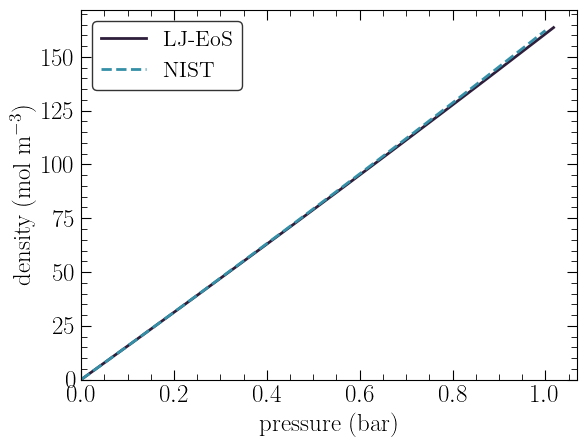

In [4]:
nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1, 
                    usecols=[1,2], names=['Pressure (bar)','Density (mol/m3)'])

colors = sns.color_palette("mako")

plt.plot(P*1e-5, bulk_density*1e30/(NA), '-', color=colors[0], linewidth=2.0, label='LJ-EoS')
plt.plot(nist['Pressure (bar)'],nist['Density (mol/m3)'], '--', color=colors[3], linewidth=2.0, label='NIST')
plt.xlabel(r'pressure (bar)', fontsize=18)
plt.ylabel(r'density (mol m$^{-3}$)', fontsize=18)
plt.xlim([0.0,None])
plt.ylim([0.0,None])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [5]:
data = pd.DataFrame()
data['P/P0'] = P.numpy()/P0
H = 36.0
system_size = H+10
points = int(system_size*100)

def steele(z,sigma,epsilon):
        rhos = 0.114
        Delta = 3.35
        return 2.0*pi*rhos*epsilon*sigma**2*Delta*(0.40*(sigma/z)**10-(sigma/z)**4-sigma**4/(3.0*Delta*(z+0.610*Delta)**3))

sigma_s = 3.40
epsilon_s = 28.0
sigma_is = 0.5*(sigma+sigma_s) 
epsilon_is = np.sqrt(epsilon*epsilon_s)

dft = dft_core(parameters, T, system_size, points, device)
Vext = np.zeros(dft.points, dtype=np.float64)
kin = 500
kout = int(system_size*100-kin)
Vext[0:kin] = np.inf
Vext[kout:] = np.inf
Vext[kin:kout] = steele(dft.z[kin:kout].numpy()-5, sigma_is, epsilon_is)+steele(H-(dft.z[kin:kout].numpy()-5), sigma_is, epsilon_is)

dft.initial_condition(bulk_density[0],Vext)
Nads = torch.empty_like(P)
Ndes = torch.empty_like(P) 
Omega_ads = torch.empty_like(P)
Omega_des = torch.empty_like(P)
for i in range(len(P)):
        dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',
                                        solver='fire',alpha0=0.2,dt=0.01,tol=1e-6,logoutput=False)
        Nads[i] = (1e20/NA)*(dft.total_molecules)
        Omega_ads[i] = dft.Omega
        print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())   
        if np.isnan(dft.error.numpy()): break

Ndes[-1] = (1e20/NA)*(dft.total_molecules)
Omega_des[-1] = dft.Omega
for i in range(len(P)-2,-1,-1):
        dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',
                                        solver='fire',alpha0=0.2,dt=0.01,tol=1e-6,logoutput=False)
        Ndes[i] = (1e20/NA)*(dft.total_molecules)
        Omega_des[i] = dft.Omega
        print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())   
        if np.isnan(dft.error.numpy()): break

127 8.910216420849417e-07 1e-07 8.117805113379193e-10
124 8.055819745750554e-07 1.5e-07 1.2177595082886148e-09
122 9.596292606309783e-07 2e-07 1.6238036443682717e-09
120 9.957002424995176e-07 2.5e-07 2.0299102768677215e-09
118 9.848232853892893e-07 3e-07 2.436079394594373e-09
115 9.91844332313909e-07 3.4999999999999993e-07 2.8423108459539326e-09
110 9.984207299450566e-07 4e-07 3.2486047027685156e-09
102 9.959018052395879e-07 4.5e-07 3.6549610315727266e-09
89 9.77316891113872e-07 5e-07 4.061379917436778e-09
89 9.116218732967419e-07 5.5e-07 4.4678616038991545e-09
89 8.576855339710331e-07 6e-07 4.874405786715342e-09
89 8.126738333852781e-07 6.499999999999999e-07 5.28101248607514e-09
89 7.745948194431996e-07 6.999999999999999e-07 5.687681721953266e-09
89 7.420077917472656e-07 7.5e-07 6.094413514184641e-09
89 7.13844976874083e-07 8e-07 6.501207882513401e-09
89 6.892982026576208e-07 8.499999999999999e-07 6.908064846623599e-09
89 6.677445665741738e-07 9e-07 7.314984426156443e-09
89 6.48696233

In [9]:
Neq = np.copy(Nads)
Omega_eq = np.copy(Omega_ads)
for i in range(len(P)):
    if Omega_des[i] < Omega_ads[i]:
        Omega_eq[i] = Omega_des[i]
        Neq[i] = Ndes[i]

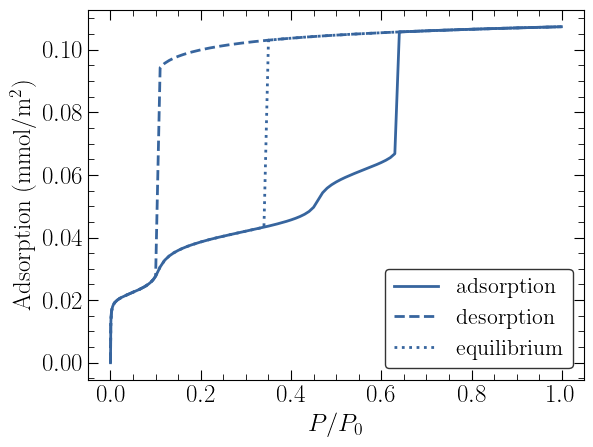

In [11]:
mc = np.loadtxt('data/N2_36A_MC.dat')
colors = sns.color_palette("mako")

plt.plot(P/P0, Nads*1e3, '-', color=colors[2], linewidth=2.0, label='adsorption')
plt.plot(P/P0, Ndes*1e3, '--', color=colors[2], linewidth=2.0, label='desorption')
plt.plot(P/P0, Neq*1e3, ':', color=colors[2], linewidth=2.0, label='equilibrium')
plt.xlabel(r'$P/P_0$', fontsize=18)
plt.ylabel(r'Adsorption (mmol/m$^2$)', fontsize=18)
# plt.xlim([0.0,0.4])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

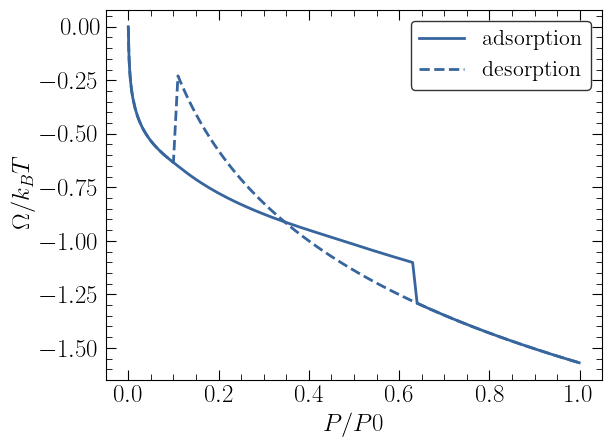

In [12]:
mc = np.loadtxt('data/N2_36A_MC.dat')
colors = sns.color_palette("mako")

plt.plot(P/P0, Omega_ads, '-', color=colors[2], linewidth=2.0, label='adsorption')
plt.plot(P/P0, Omega_des, '--', color=colors[2], linewidth=2.0, label='desorption')
plt.xlabel(r'$P/P0$', fontsize=18)
plt.ylabel(r'$\Omega/k_B T$', fontsize=18)
# plt.xlim([0.0,5.0])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')